In [1]:
import numpy as np
from matplotlib import pyplot as plt
from astroML.linear_model import PolynomialRegression, BasisFunctionRegression, NadarayaWatson
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from astropy.cosmology import FlatLambdaCDM, LambdaCDM
import scipy
from scipy.stats import uniform
import dynesty
from dynesty import plotting as dyplot
from dynesty import utils    as dyfunc

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Let's recall the definition of magnitude and the distance modulus
$$
\mu = m-M =  5 \log_{10}\left(\frac{d_L}{\rm pc}\right) - 5
$$
These are some (synthetic but realistic; see textbook) supernova data

(35.0, 50.0)

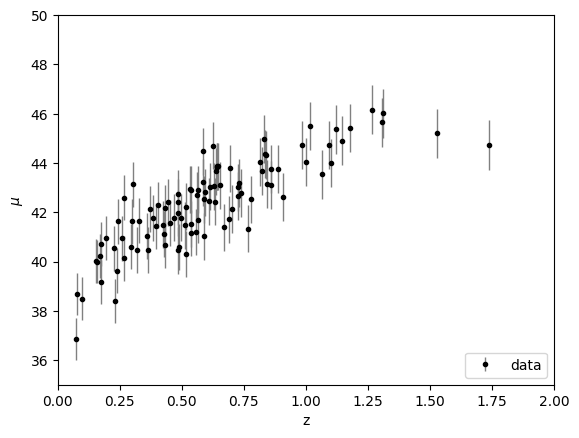

In [2]:
from astroML.datasets import generate_mu_z
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel('z')
plt.ylabel('$\mu$')
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

# L17

####  Tasks

- First, explore fitting this data with the tecniques we have seen.
- Start from linear regression and polynomial regression
- For the case of  polynomial regression, just fit many of them for now.
- Let's bet based on intuition! Which fit is the best?
- In what cases are you underfitting the data?
- In what cases are you overfitting the data?
- Now split the data into training and validation sets
- Implement a cross-validation procedure
- Pick the best!
- Does it agree with our bets?

## Linear regression

y = mx + q
m =  4.7643886477497945 
q =  39.483846022957295


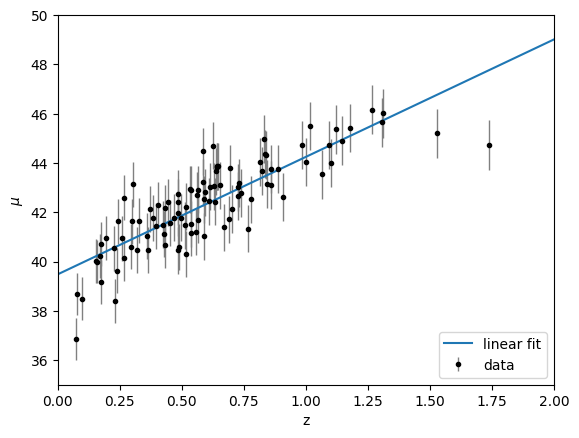

In [3]:
z     = z_sample.copy()[:,np.newaxis]
model = LinearRegression()

# I am like 75% conviced of this for the sample_weight...
model.fit(z, mu_sample, sample_weight=1/dmu**2)

print('y = mx + q\nm = ', model.coef_[0], '\nq = ', model.intercept_)

# y = mx + q
x_fit = np.linspace(0, 2, 1000)[:,np.newaxis]
y     = model.predict(x_fit)

plt.errorbar(z, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='data')
plt.plot(x_fit,y, label= 'linear fit')

plt.xlabel('z')
plt.ylabel('$\mu$')
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()

## Polynomial regression 

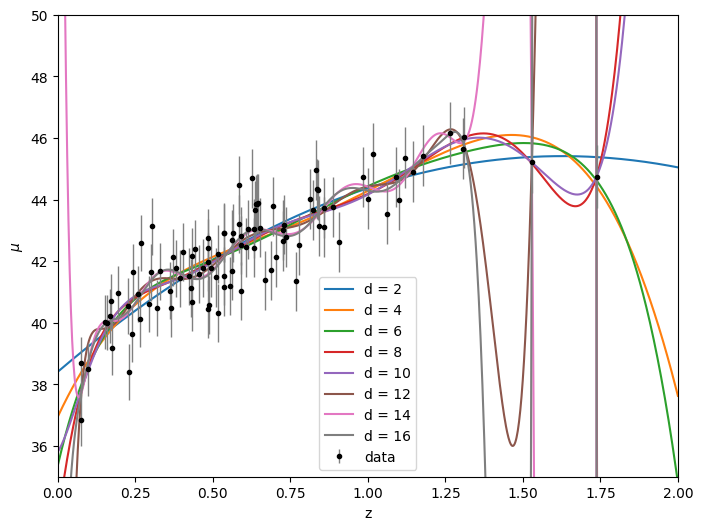

In [4]:
plt.figure(figsize=(8,6))
for d in np.arange(2, 17, 2):
    
    model = PolynomialRegression(d)
    model.fit(z, mu_sample, dmu)
    y_pred = model.predict(x_fit)
    plt.plot(x_fit, y_pred, label='d = '+ str(d))
    
plt.errorbar(z, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel('z')
plt.ylabel('$\mu$')
plt.xlim(0,2)
plt.ylim(35,50)
plt.legend()
plt.show()

By eye, the linear model underfit the data, but higher polinomial degree (more than $4$ or $6$) overfit the data. <br>
As expected, the more parameters in the model I have, the more I overfit the data.

## Cross-validation

With polynomical regression, I took the degree by eye. But to decide which model to use I can see which model performs the best, training the model and then see what are the results on validation. <br>
To do this, I can divide the data like this:

In [5]:
xtrain, xtest, ytrain, ytest = train_test_split(z_sample, mu_sample, test_size=0.2)

But in this way I don't know which amount of data I need to use to have the bast fit. For now I have split $20%$ of data into validation and $80%$ in train, but maybe it is not the best choice. <br>
Let's use learning curves to decide what division to make, LearningCurve evaluates a model performance in function of the different sizes of the train dataset:

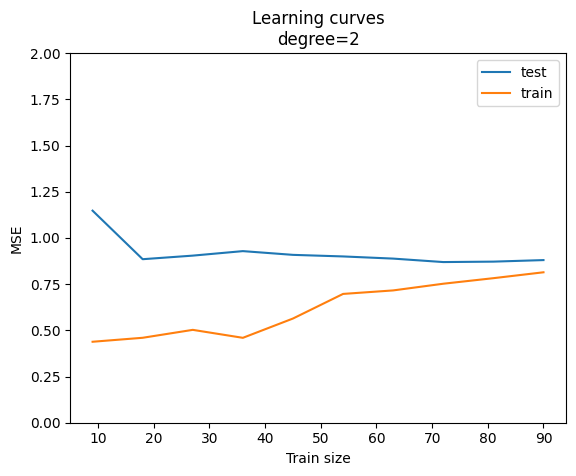

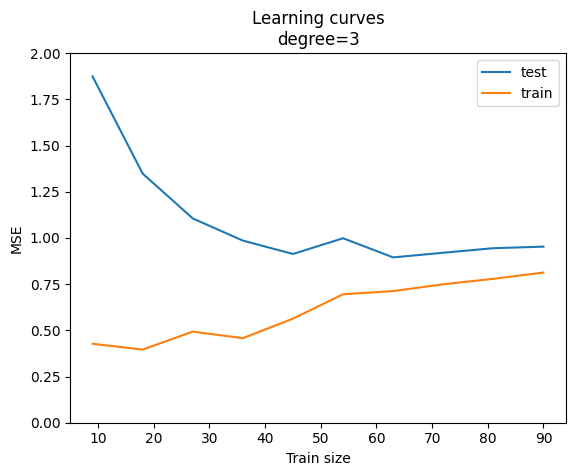

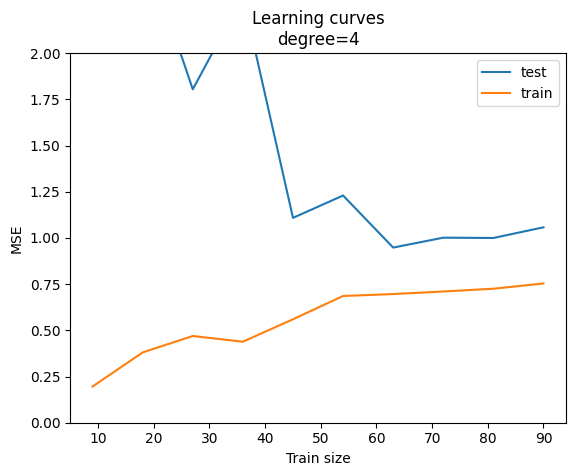

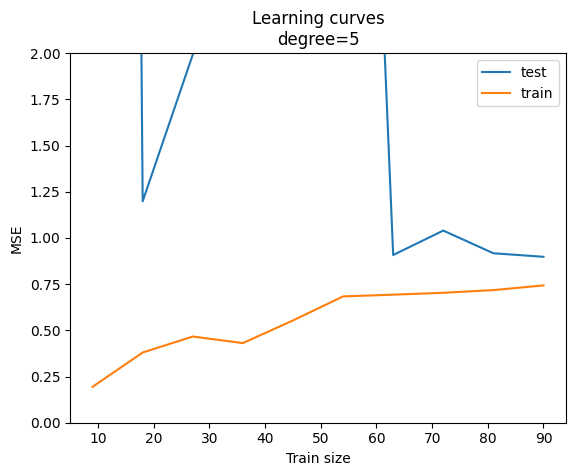

In [6]:
# Since by eye 6 degrees are too much, I am going to stop there
for d in np.arange(2, 6, 1):
    
    model = PolynomialRegression(d)

    # it divides the dataset in 'cv' parts, one is left out as a test. On the other ones, it takes train_size percentage to train on
    # cv = 10 -> cross-validation: each points in the plots below is the average on 10 folds
    train_sizes, train_scores, test_scores = learning_curve(model, z, mu_sample, train_sizes=np.linspace(0.1, 1.0, 10), scoring="neg_mean_squared_error", cv=10, fit_params={'y_error':dmu})
    # minus (-) because of how sklearn works, it prefers to maximize things, but I want the errors
    plt.plot(train_sizes, -test_scores.mean(axis=1), label='test')
    plt.plot(train_sizes, -train_scores.mean(axis=1), label='train')
                       
    plt.xlabel('Train size')
    plt.ylabel('MSE')
    plt.title('Learning curves\ndegree='+str(d))
    plt.legend(loc='best')
    plt.ylim(0,2)
    plt.show()

The two errors almost converge, but the train error is still lower than the test one, it is better to take a conservative high number of point. <br>
Let'd do $80%$.

Now I can use it to determine which number of degrees is best for my model!

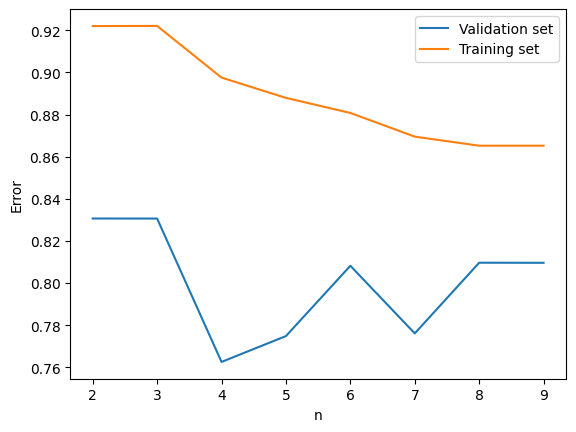

Best degree 4  with error value =  0.7625684993959875


In [7]:
def error(x, y, model):
    return np.sqrt(np.sum((model.predict(x) - y) ** 2)/ len(y))

xtrain, xtest, ydytrain, ydytest = train_test_split(z, np.array([mu_sample, dmu]).T, test_size=0.2)
ytrain, dytrain = ydytrain.T
ytest,  dytest  = ydytest.T
err_train = []
err_test  = []
degrees = np.arange(2, 10, 1)
for d in degrees:
    
    model = PolynomialRegression(d)
    model.fit(xtrain, ytrain, dytrain)
    err_train.append(error(xtrain, ytrain, model))
    err_test.append(error(xtest, ytest, model))

plt.plot(degrees, err_test, label='Validation set')
plt.plot(degrees, err_train, label='Training set')

plt.xlabel('n')
plt.ylabel('Error')
plt.legend()
plt.show()

print('Best degree', degrees[np.argmin(err_test)], ' with error value = ', min(err_test))

## Others regression methods

### Basis Function Regression

I want to try another regression method, the basis function regression. <br>
It transorms the input space into a new input space that can represent non-linear relashionships. <br>
In this case, I am going to try a gaussian basis. <br>
The inputs z are transformed by a gaussian function centered at certain points; these new inputs are then fit linearly.

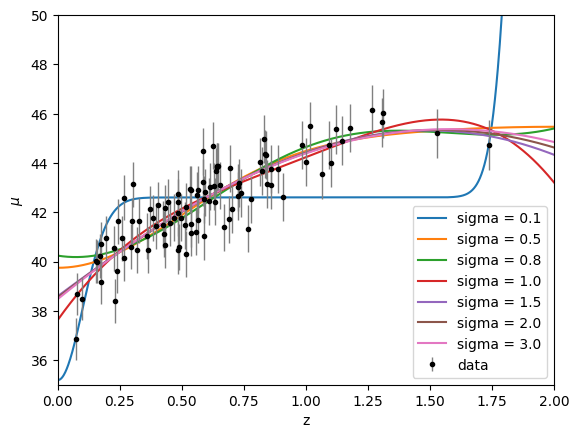

In [8]:
# mean positions of the i Gaussians in the model
# I am using 2, but I could do a similar thing to the polynomial regression and see how many gaussian I need
x_grid = np.linspace(0, 2, 2)[:, None]

for sigma in [0.1,0.5,0.8,1.0,1.5,2.0,3.0]:
    
    model = BasisFunctionRegression('gaussian', mu = x_grid, sigma=sigma)
    model.fit(z, mu_sample, dmu)
    y_pred = model.predict(x_fit)
    plt.plot(x_fit, y_pred, label='sigma = '+ str(sigma))
    
plt.errorbar(z, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel('z')
plt.ylabel('$\mu$')
plt.xlim(0,2)
plt.ylim(35,50)
plt.legend()
plt.show()

## Kernel Regression

This uses Gaussian (or others) kernels to measure similarities between points. <br>
It basically weight the data bases on the vicinity to the 'query' points, in <br>
Also here, to estimate the best band-width I could use cross-validation.

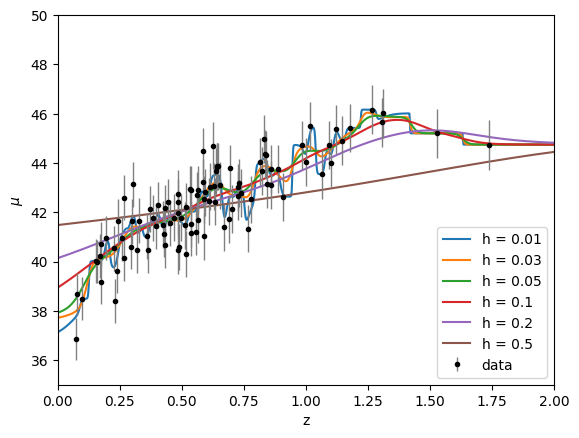

In [9]:
# h = bandwidth
for h in [0.01,0.03,0.05,0.10,0.20,0.50]:
    model = NadarayaWatson(kernel='gaussian', h=h)
    model.fit(z, mu_sample, dmu)
    y_pred = model.predict(x_fit)
    plt.plot(x_fit, y_pred, label='h = '+ str(h))
    
plt.errorbar(z, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel('z')
plt.ylabel('$\mu$')
plt.xlim(0,2)
plt.ylim(35,50)
plt.legend(loc='lower right')
plt.show()

# L18

## Gaussian Processes

First let's fit our supernova synthetic data from last time using GPR.

- The key ingrediente in getting a good GPR fit is the choice of the kernel and its parameters.
- Check out what's available in the `kernels` submodule of [sklearn.gaussian_process](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.gaussian_process)
- *Hint*. Radial-basis function kernel (aka squared-exponential kernel) is a standard choice in the GPR world.
- Plot the expectation value of the fit as well as the resulting 1-$\sigma$ and 2-$\sigma$ contours.
- Interpret the results.

RBF(length_scale=3.9) * 30.7**2
RationalQuadratic(alpha=0.0218, length_scale=5.84) * 38.5**2


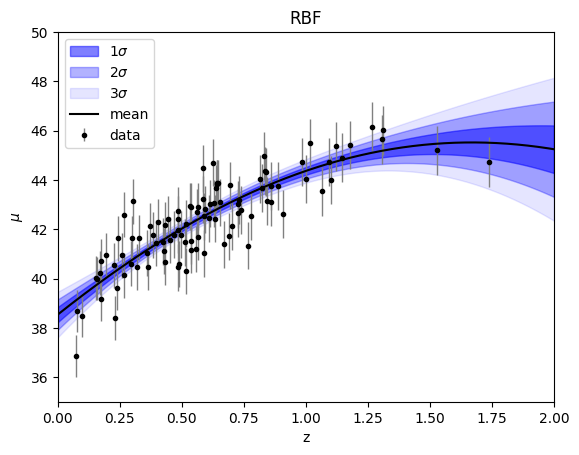

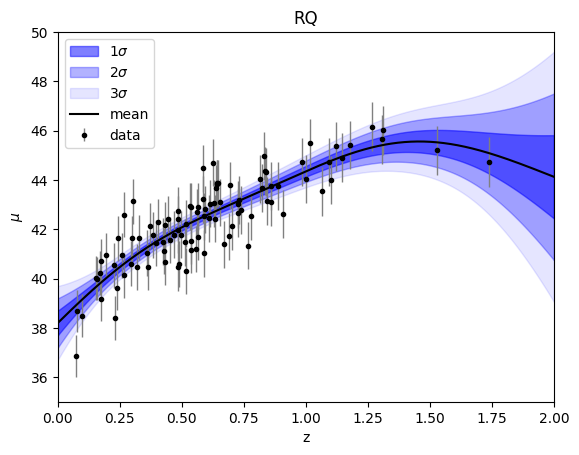

In [10]:
# I will try tow kernels, both are multiplied by a constant kernel (parameter = constant value) that scales the amplitude
# First, try with a Radial-Basis function kernel
# it depends only on how close 2 points are, it's the squared exponential kernel 
# parameter: -> scale(sigma) = how far 2 points must be to stop influencing each other
# gaussian process optimize the parameters itself during raining 
kernel_rbf = kernels.RBF() * kernels.ConstantKernel()
#alpha is the variance on the training set
gaussian_process_rbf = GaussianProcessRegressor(kernel=kernel_rbf, alpha=dmu**2)
gaussian_process_rbf.fit(z, mu_sample)
mean_rbf, std_dev_rbf = gaussian_process_rbf.predict(x_fit, return_std=True)
print(gaussian_process_rbf.kernel_)

# Then, I will try a rational quadratic kernel; it's similar to rbf, but in addition to the lenght scale in 2*L^2
# it has 2*alpha*L^2, where alpha is a shape parameter. rq is like a weighted sum of rbf, each one with an L
# alpha controls how much this L can change
kernel_rq = kernels.RationalQuadratic() * kernels.ConstantKernel()
#alpha is the variance on the training set
gaussian_process_rq = GaussianProcessRegressor(kernel=kernel_rq, alpha=dmu**2)
gaussian_process_rq.fit(z, mu_sample)
mean_rq, std_dev_rq = gaussian_process_rq.predict(x_fit, return_std=True)
print(gaussian_process_rq.kernel_)

# Plot
plt.errorbar(z, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='data')
plt.fill_between(x_fit[:,0], mean_rbf - 1 * std_dev_rbf, mean_rbf + 1 * std_dev_rbf, color='blue', alpha=0.5, label='1$\sigma$')
plt.fill_between(x_fit[:,0], mean_rbf - 2 * std_dev_rbf, mean_rbf + 2 * std_dev_rbf, color='blue', alpha=0.3, label='2$\sigma$')
plt.fill_between(x_fit[:,0], mean_rbf - 3 * std_dev_rbf, mean_rbf + 3 * std_dev_rbf, color='blue', alpha=0.1, label='3$\sigma$')
plt.plot(x_fit, mean_rbf, label='mean', c='black')
plt.title('RBF')
plt.xlabel('z')
plt.ylabel('$\mu$')
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)
plt.legend()
plt.show()

plt.errorbar(z, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='data')
plt.fill_between(x_fit[:,0], mean_rq - 1 * std_dev_rq, mean_rq + 1 * std_dev_rq, color='blue', alpha=0.5, label='1$\sigma$')
plt.fill_between(x_fit[:,0], mean_rq - 2 * std_dev_rq, mean_rq + 2 * std_dev_rq, color='blue', alpha=0.3, label='2$\sigma$')
plt.fill_between(x_fit[:,0], mean_rq - 3 * std_dev_rq, mean_rq + 3 * std_dev_rq, color='blue', alpha=0.1, label='3$\sigma$')
plt.plot(x_fit, mean_rq, label='mean', c='black')
plt.title('RQ')
plt.xlabel('z')
plt.ylabel('$\mu$')
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)
plt.legend()
plt.show()

The black line (the average) matches the data very weel, and the sigma regions give the impression that at large redshift the model is not a lot constrainted.

## Fit the data

We now have a suite of *data-drive predictive models* for our supernova dataset. That is: we can faithfully predict how a future redshift/distance measurement will look like given the current sample.

This is already great and these kind of tools are immensely useful in a variety of contexts (also involving a lot of money: suppose you want to predict how much a give financial asset will perform on tomorrow's stock market... You  might not really care about expressing the underlying financial model in simple terms, as long as your investments are profitable).

For the case of supernovae, however, we have do have physical theory which is $\Lambda$CDM.

- First, refresh your cosmology and write down the predicted relationship between the distance module $\mu$ and the redshift $\sigma$. *Hint* I always forget these things, my to-go reference is [Hogg (2010)](https://arxiv.org/abs/astro-ph/9905116). I got:

$$\mu = 5 \log \left( \frac{c/H_0} {10 {\rm pc}}(1+z)\int_0^z \frac{dz'}{\sqrt{\Omega_m (1+z^3)+\Omega_\Lambda}} \right) $$


- Assuming a flat Universe,  we have a parametric non-linear model for $\mu(z)$ that depends on two parameters, the Hubble constant $H_0$ and the matter content of the Universe $\Omega_m$
- It's a very non-linear model. Fit it to the data (however you want to do it).
- What are the measured value of $H_0$ and $\Omega_m$. Are they correlated?
- How would a model without dark energy (i.e. $\Omega_m=1$) perform? Do these data contain evidence of dark energy? (Hint: this is a model selection problem!)

-> I want to determine the values of parameters $H_0$ and $\Omega_m$, but I also want to compare two different models (with and without dark energy). <br>
For this, I think it is better to use a Nested Sampling algorithm.

In [11]:
# Number of parameters I want to constrain
# with DARK ENERGY
dimension_de = 2
# without DARK ENERGY
dimension    = 1

# The model already exists, I'm using that one
# with DARK ENERGY
def model_cosmo_de(p, z):
    H_0, O_m = p
    universe = FlatLambdaCDM(H0=H_0, Om0=O_m)
    # I need the modulus in magnitudes
    return universe.distmod(z).value

# without DARK ENERGY
def model_cosmo(p, z):
    H_0 = p[0]
    universe = FlatLambdaCDM(H0=H_0, Om0=1)
    # I need the modulus in magnitudes
    return universe.distmod(z).value

# Define the likelihood, I don't anything about it, so I just assume it's Gaussian
# with DARK ENERGY
def loglikelihood_de(p, error_mu, mu, z):
    #H_0, O_m = p
    logL = np.sum(np.log((1/((2*np.pi)**(1/2)*error_mu)))) + np.sum(-(mu - model_cosmo_de(p, z))**2 / 2 /error_mu**2)
    if not np.isfinite(logL):
        return -np.inf
    else:
        return logL
        
# without DARK ENERGY
def loglikelihood(p, error_mu, mu, z):
    #H_0 = p
    logL = np.sum(np.log((1/((2*np.pi)**(1/2)*error_mu)))) + np.sum(-(mu - model_cosmo(p, z))**2 / 2 /error_mu**2)
    if not np.isfinite(logL):
        return -np.inf
    else:
        return logL
        
# For the prior I know that the omerga_matter should be between 0 and 1
# for the H_0 let's say that can be in a uniform distribution between 50 and 100
# with DARK ENERGY
def prior_transform_de(u):
    H_0 = scipy.stats.uniform.ppf(u[0], loc=30, scale=70)
    O_m = u[1] * 1
    return np.array([H_0, O_m])
    
# without DARK ENERGY
def prior_transform(u):
    H_0 = scipy.stats.uniform.ppf(u[0], loc=30, scale=70)
    return np.array([H_0])

In [12]:
# with DARK ENERGY
sampler_de = dynesty.NestedSampler(loglikelihood_de, prior_transform_de, dimension_de, nlive=1000, logl_args=(dmu, mu_sample, z_sample))
sampler_de.run_nested()
# .results retrieve results like :log-evidence (logz), posterior samples (samples), weights (logwt)
results_de = sampler_de.results

2854it [00:17, 162.61it/s, +1000 | bound: 0 | nc: 1 | ncall: 17533 | eff(%): 23.311 | loglstar:   -inf < -132.814 <    inf | logz: -135.388 +/-  0.025 | dlogz:  0.001 >  1.009]


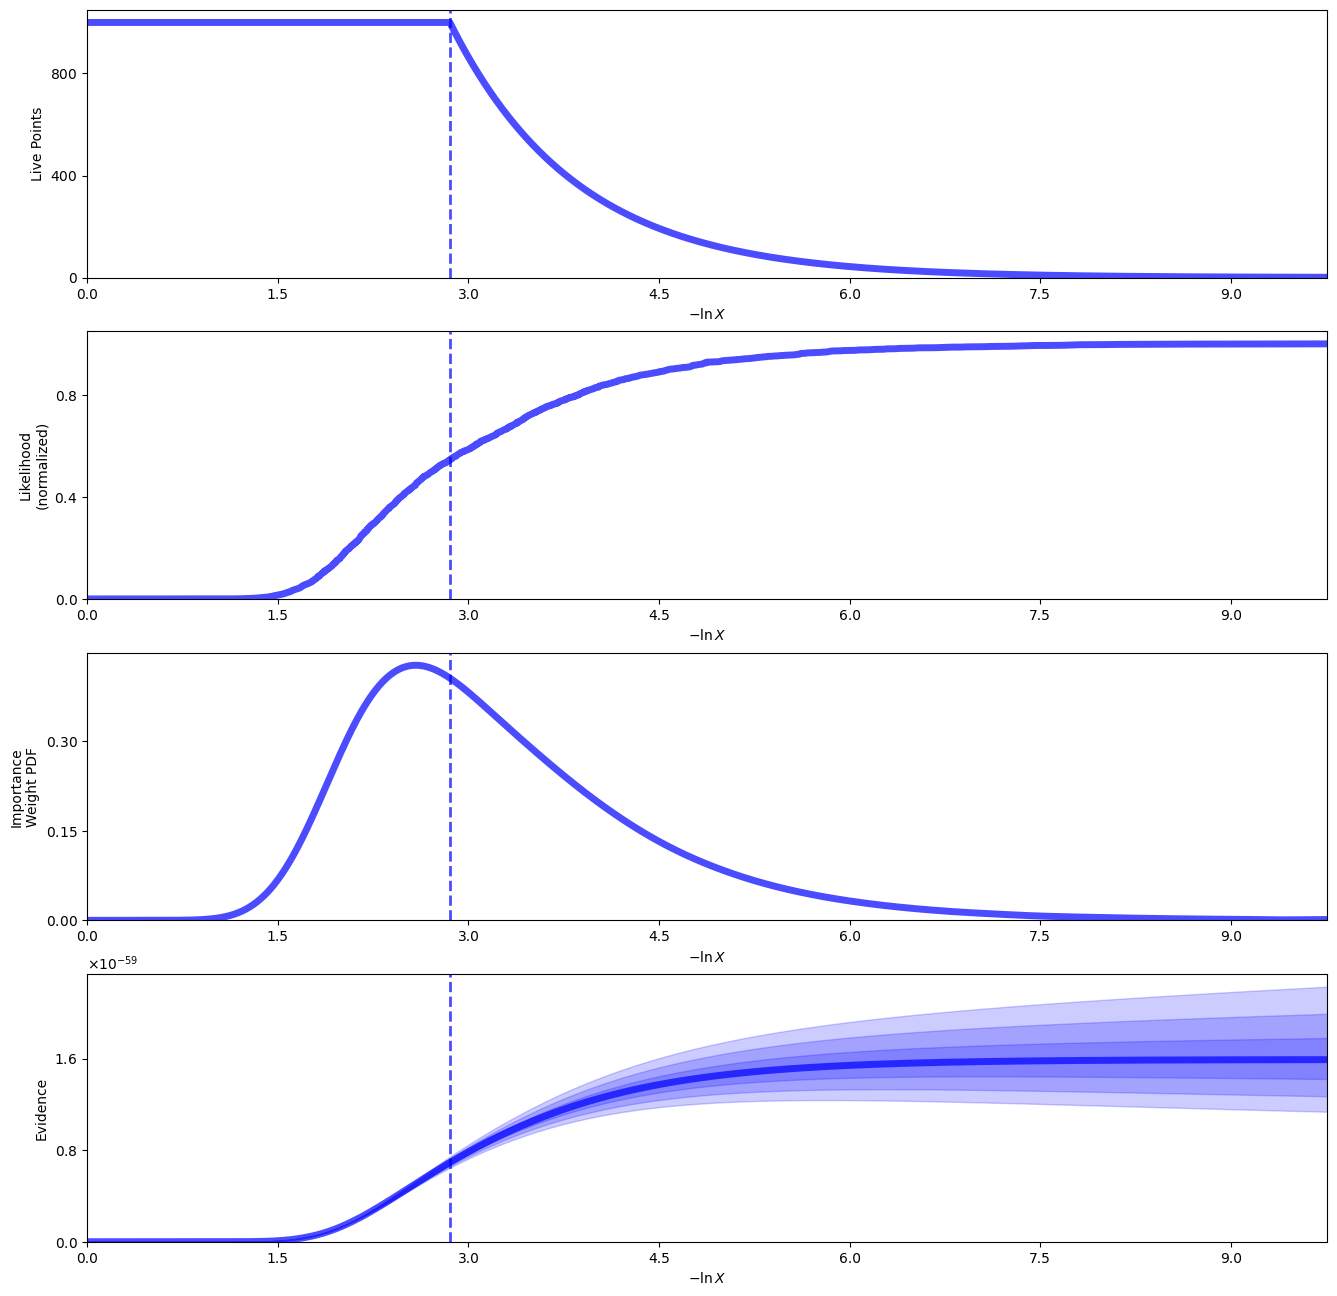

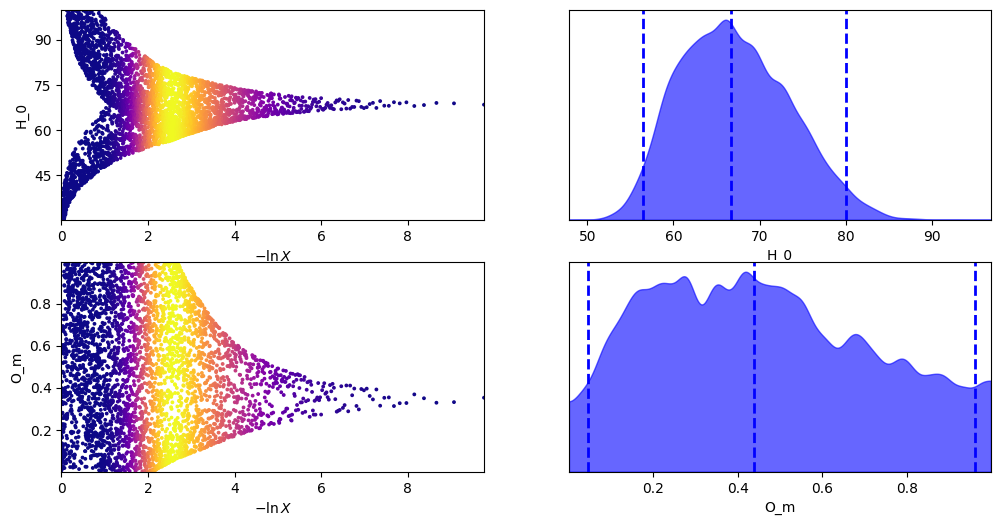

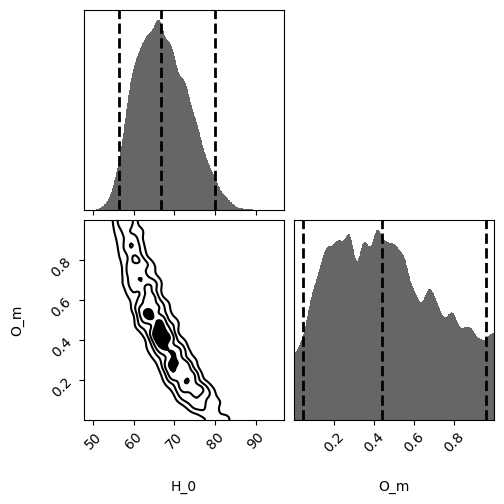

In [13]:
results_de  = sampler_de.results
rfig, raxes = dyplot.runplot(results_de)
tfig, taxes = dyplot.traceplot(results_de, labels=['H_0', 'O_m'])
cfig, caxes = dyplot.cornerplot(results_de,labels=['H_0', 'O_m'])

From the corner plot, I can clearly see that omega matter and H0 are correlated!

In [14]:
# without DARK ENERGY
sampler = dynesty.NestedSampler(loglikelihood, prior_transform, dimension, nlive=1000, logl_args=(dmu, mu_sample, z_sample))
sampler.run_nested()
# .results retrieve results like :log-evidence (logz), posterior samples (samples), weights (logwt)
results = sampler.results

2818it [00:14, 198.51it/s, +1000 | bound: 0 | nc: 1 | ncall: 17773 | eff(%): 22.763 | loglstar:   -inf < -133.530 <    inf | logz: -135.964 +/-    nan | dlogz:  0.001 >  1.009]


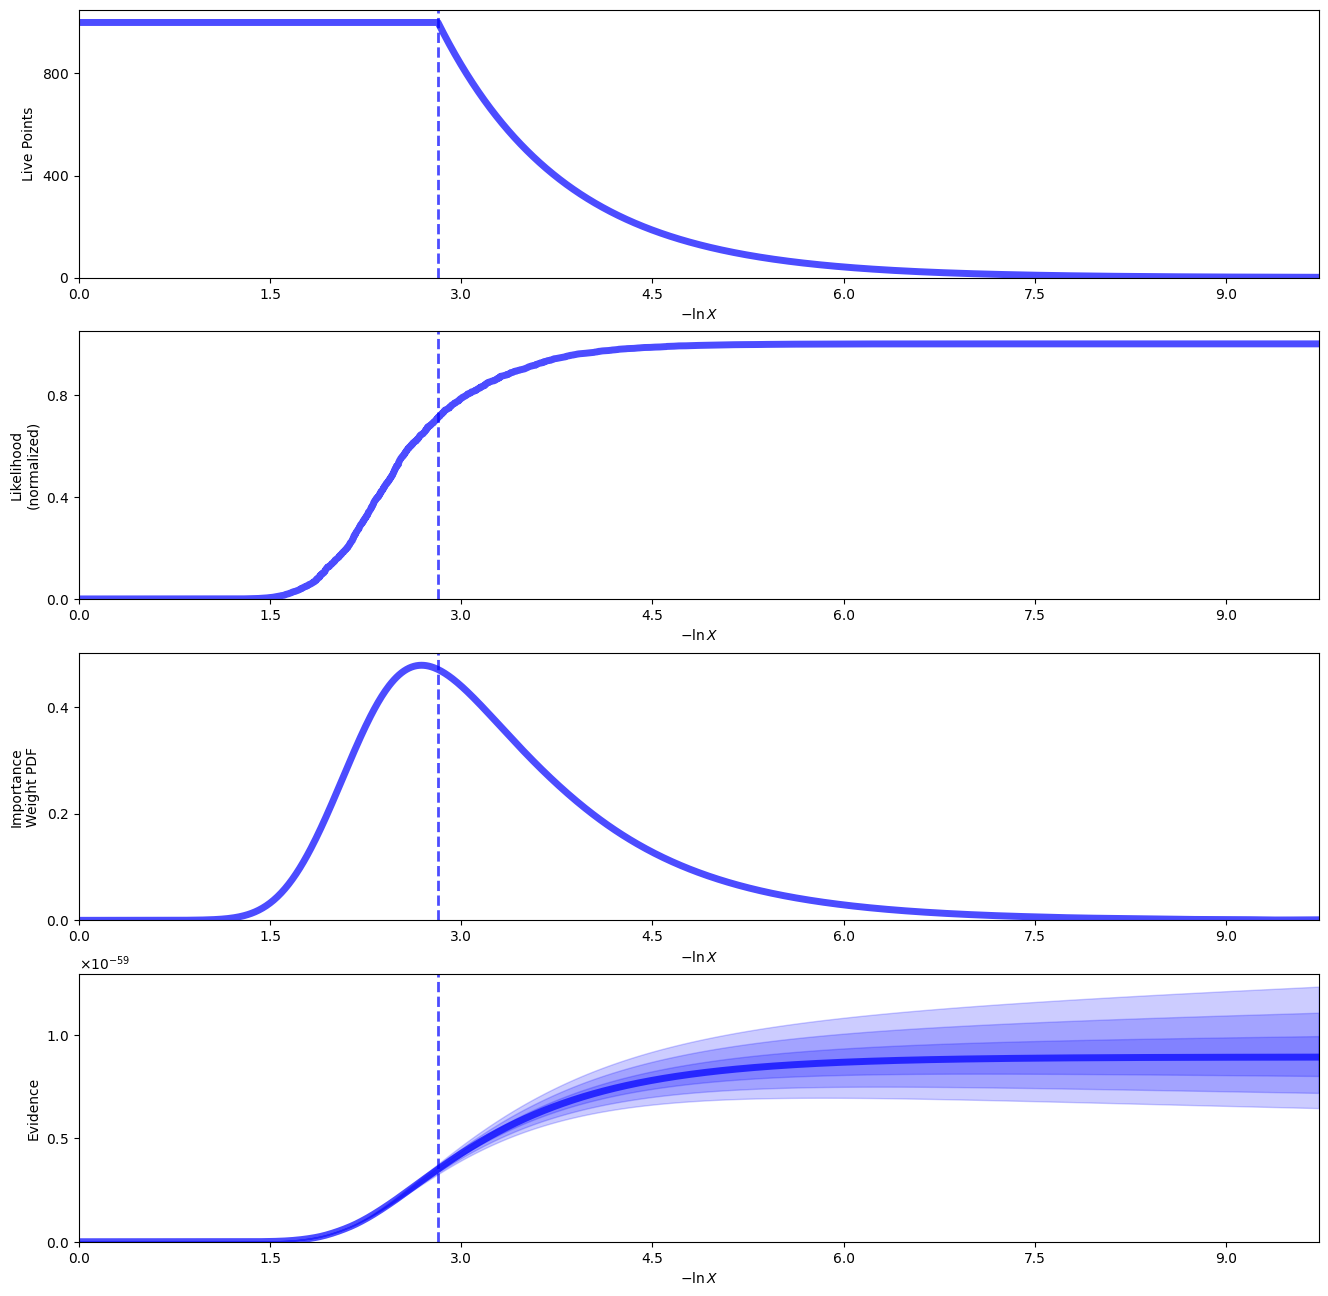

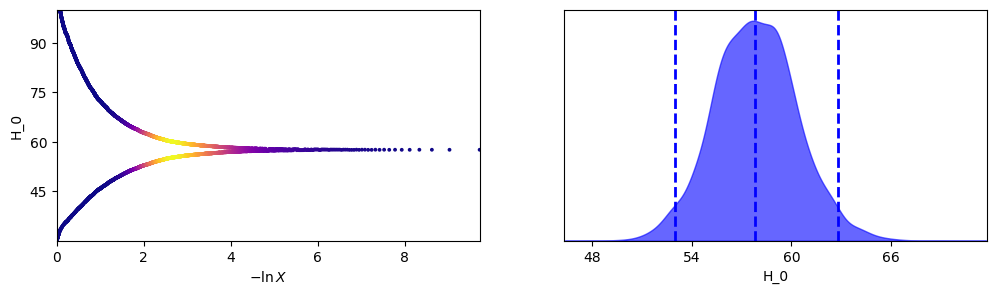

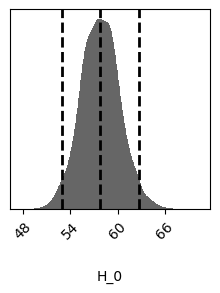

In [15]:
results  = sampler.results
rfig, raxes = dyplot.runplot(results)
tfig, taxes = dyplot.traceplot(results, labels=['H_0'])
cfig, caxes = dyplot.cornerplot(results,labels=['H_0'])

In [16]:
# with DARK ENERGY
print('with dark energy:')
samples_de = results_de.samples
weights_de = np.exp(results_de.logwt - results_de.logz[-1])
# compute quantiles
labels_de    = ['H_0', 'O_m']
quantiles_de = [dyfunc.quantile(samps, [0.05,0.5,0.95], weights = weights_de) for samps in samples_de.T] #.T so every row is a parameter
median_H0 = quantiles_de[0][1]
median_Om = quantiles_de[1][1]
for q,l in zip(quantiles_de, (labels_de)):
    p5, median, p95 = q
    print(l+':  ', round(median,3), '  +', round(p95-median,3), '  -', round(median-p5,3))


# without DARK ENERGY
print('\nwithout dark energy:')
samples = results.samples
weights = np.exp(results.logwt - results.logz[-1])
# compute quantiles
labels    = ['H_0']
quantiles = [dyfunc.quantile(samps, [0.05,0.5,0.95], weights = weights) for samps in samples.T] #.T so every row is a parameter
median_H0_only = quantiles[0][1]
for q,l in zip(quantiles, (labels)):
    p5, median, p95 = q
    print(l+':  ', round(median,3), '  +', round(p95-median,3), '  -', round(median-p5,3))

with dark energy:
H_0:   66.628   + 11.486   - 8.936
O_m:   0.438   + 0.48   - 0.355

without dark energy:
H_0:   57.8   + 4.155   - 3.969


The value found for H0 without dark energy is smaller than the estimate in the model with dark energy. <br>
This agrees to the fact that there is a correlation with omega_m.

/home/elenasofiamangola/.local/lib/python3.10/site-packages/astropy/cosmology/flrw/base.py:1352: RuntimeWarning: divide by zero encountered in log10
  val = 5.0 * np.log10(abs(self.luminosity_distance(z).value)) + 25.0


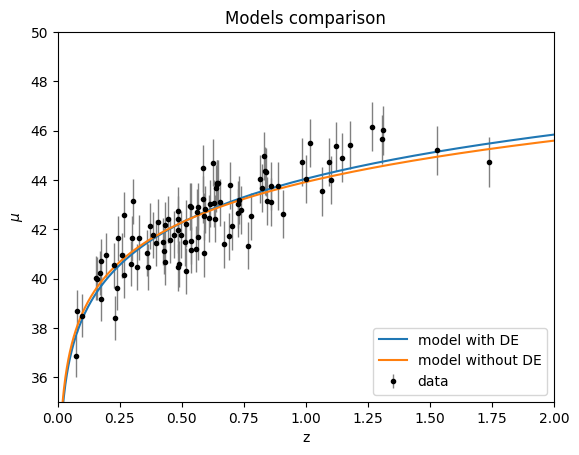

In [17]:
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='data')

y_de = model_cosmo_de([median_H0, median_Om], x_fit)
y    = model_cosmo([median_H0_only], x_fit)

plt.plot(x_fit, y_de, label='model with DE')
plt.plot(x_fit, y, label='model without DE')

plt.xlabel('z')
plt.ylabel('$\mu$')
plt.title('Models comparison')
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()

The two models are very similar, to see if effectively the addition of dark energy gives a better model, I am computing the ratio of the evidences:

In [18]:
# Print out the log-evidence (marginal likelihood)
print("Log-evidence for model with dark energy:", results_de.logz[-1], ' +- ', results_de.logzerr[-1])
print("Log-evidence for model without dark energy:", results.logz[-1], ' +- ', results.logzerr[-1])
print('Ratio between DE and no_DE = ', np.exp(results_de.logz[-1])/np.exp(results.logz[-1]))

Log-evidence for model with dark energy: -135.38841387965826  +-  0.11236931349467812
Log-evidence for model without dark energy: -135.96447331643918  +-  0.10777153510476378
Ratio between DE and no_DE =  1.7790142820422925


The ratio (Bayes factor) is really close to $1$. <br>
This means that there isn't a favourable model (at least, with this dataset).

## Clone the data

The European Space Agency is considering new cosmology-related space mission. They ask you to figure out what science you can do with 10 times more measurement compared to what you have right now. That is: you want to clone your data. We've seen this earlier in the class, but now we can do much better.
- Assume a uniform distribution in redshifts between 0 and z.

In [19]:
new_z = uniform.rvs(0,np.max(z_sample),1000)

- Using both the GPR fit and your latest $\Lambda$CDM fit, generate a set of $\mu$ measurements that respects the statistical properties of the data you were given.

In [20]:
# lambdaCDM fit (with DE)
# resample_equal takes the posterior samples and corresponding weights and return an 'equally weighted' set of samples
samples_eq_de = dyfunc.resample_equal(samples_de, weights_de)
samples_eq    = dyfunc.resample_equal(samples, weights)
# pick a random couple of values
mu_without_de = []
mu_with_de    = []
mu_gpr        = []
for z in new_z:
    H0_Om      = samples_eq_de[np.random.randint(len(samples_eq_de))]
    mu_with_de.append(model_cosmo_de(H0_Om, z))
    H0            = samples_eq[np.random.randint(len(samples_eq))]
    mu_without_de.append(model_cosmo(H0, z))
    # GPR with RBF
    mu_gpr_, std_gpr = gaussian_process_rbf.predict([[z]], return_std=True)
    mu_gpr.append(np.random.normal(loc=mu_gpr_,scale=std_gpr))

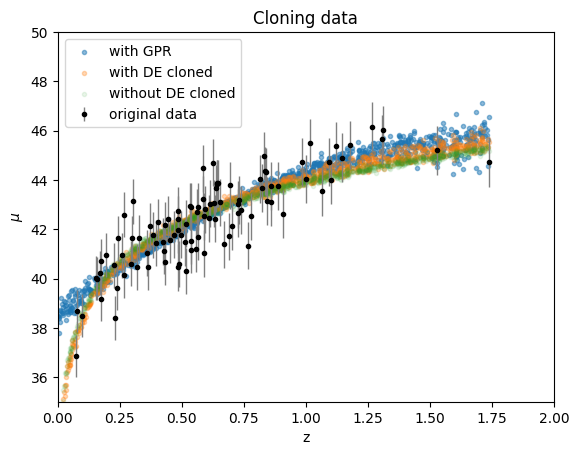

In [21]:
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='original data')
plt.scatter(new_z, mu_gpr, marker = '.', alpha=0.5, label='with GPR')
plt.scatter(new_z, mu_with_de, marker = '.', alpha=0.3, label='with DE cloned')
plt.scatter(new_z, mu_without_de, marker = '.', alpha=0.1, label='without DE cloned')
plt.xlabel('z')
plt.ylabel('$\mu$')
plt.title('Cloning data')
plt.legend(loc='best')
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()

The cloned points with GPR are data-driven; instead the cloned points with nested sampling are theory-driven"